# Project 4: Spam Filtering using Naive Bayes

**Notebook & Technical Report**

This project implements a **Naive Bayes Classifier** from scratch to filter Spam vs. Ham (legitimate) emails.

**Objective:**
To understand the probabilistic foundations of NLP (Natural Language Processing) by implementing the "Bag of Words" model and Bayesian inference without relying on high-level libraries like Scikit-learn for the core logic.

**Methodology:**
1.  **Preprocessing:** Tokenization and dataset splitting.
2.  **Training:** Calculation of prior probabilities and conditional likelihoods (with Laplace Smoothing).
3.  **Evaluation:** Performance analysis using Accuracy, Confusion Matrix, and Error Analysis (FP/FN).

Imports needed to run the practice

In [ ]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

Upload the ZIP file with all the emails

In [ ]:
!gdown 1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8
!unzip -qn "enron.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8
From (redirected): https://drive.google.com/uc?id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8&confirm=t&uuid=79013e59-281a-4c95-8655-8454eec45fa1
To: /content/enron.zip
100% 28.9M/28.9M [00:00<00:00, 66.9MB/s]


Reading emails and loading them into data structures

In [ ]:
def read_folder(folder):
    mails = []
    file_list = glob.glob(folder)  # List mails in folder
    num_files = len(file_list)
    for i in range(0, num_files):
        i_path = file_list[i]
        i_file = open(i_path, 'rb')
        i_str = i_file.read()
        i_text = i_str.decode('utf-8', errors='ignore')  # Convert to Unicode
        mails.append(i_text)  # Append to the mail structure
        i_file.close()
    return mails

def load_enron_folders(datasets):
    path = './'
    ham = []
    spam = []
    for j in datasets:
        ham  = ham  + read_folder(path + '/enron' + str(j) + '/ham/*.txt')
        spam = spam + read_folder(path + '/enron' + str(j) + '/spam/*.txt')
    num_ham  = len(ham)
    num_spam = len(spam)
    print("mails:", num_ham+num_spam)
    print("ham  :", num_ham)
    print("spam :", num_spam)

    mails = ham + spam
    labels = [0]*num_ham + [1]*num_spam
    mails, labels = shuffle(mails, labels, random_state=0)
    return mails, labels

print("Loading files...")

print("------Loading train and validation data--------")
mails, y = load_enron_folders([1,2,3,4,5])

print("--------------Loading test data----------------")
mails_test, y_test = load_enron_folders([6])

Loading files...
------Loading train and validation data--------
mails: 27716
ham  : 15045
spam : 12671
--------------Loading test data----------------
mails: 6000
ham  : 1500
spam : 4500


Code to generate a word bag that counts the number of times each word appears in the email list

Create an array X with as many rows as emails (27716) and as many columns as words in the dataset. The element (i,j) of the array contains the number of occurrences of word j in email i

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1))  # Bag of words instance with individual words as features
X = vectorizer.fit_transform(mails)               # Generation and calculation of the word bag based on training data
X_test = vectorizer.transform(mails_test)         # Calculating the word bag with the test data

Learning probabilities using a Bernoulli distribution model.

Refer to the sklearn documentation to understand the parameters.

In [ ]:
classifier = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None) # Instance of Naive Bayes classifier with Bernoulli distribution
classifier.fit(X, y) # Calculation of the probabilities associated with each word in the bag

BernoulliNB()

Calculating classifier metrics using test data

F1-score of the test: 98.78%
Confusion Matrix:
[[1429   71]
 [  39 4461]]


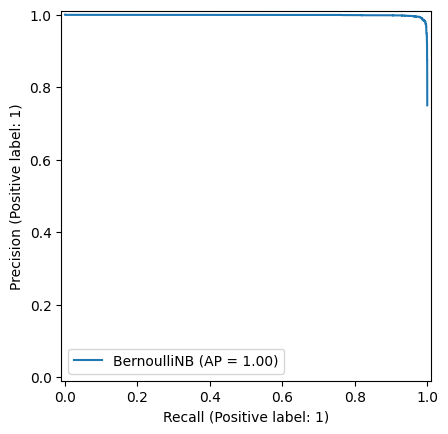

In [ ]:
y_pred = classifier.predict(X_test)
f1_score = metrics.f1_score(y_test, y_pred)
print(f"F1-score of the test: {100*f1_score:2.2f}%")
C = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)
metrics.PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test)

# **Exercises**

---




***1. Choosing the best classifier configuration***

Taking advantage of the fact that the data was already extracted in the section provided on "Reading the emails and loading them into the data structures", we divided the loaded data from Enron1-Enron5, randomly ordered into 80% data intended for training and the other 20% intended for validation:

In [ ]:
N = len(mails)

#Create a vector of N randomly mixed indices between 0 and N-1 (without repeats).
indices = np.random.permutation(N)

N_entrenamiento = int(0.8 * N)          #80% training
indices_ent = indices[:N_entrenamiento] #The first N_entrenamiento(N_training) indices are for training.
indices_val = indices[N_entrenamiento:] #The rest are for validation.

#We created the training sets:
X_ent = [mails[i] for i in indices_ent]
y_ent = [y[i] for i in indices_ent]

#We created the validation sets:
X_val = [mails[i] for i in indices_val]
y_val = [y[i] for i in indices_val]

print("Size training     :", len(X_ent))
print("Size validation   :", len(X_val))



Tamaño entrenamiento: 22172
Tamaño validación   : 5544


We created a function where we pass an alpha and test the Bernoulli and Multinomial distributions with different combinations of ngram_range. 

We return the one with the best f1_score (and optionally print the execution details).


In [ ]:

# Parameter:
#   - alpha: Laplace smoothing parameter.
#   - mostrar: if True, prints a row with all results.
#
# Test:
#   - Models: BernoulliNB and MultinomialNB.
#   - ngram_range:
#       single words only (1,1),
#       words + bigrams (1,2),
#       bigrams only (2,2)
#
# Returns:
#   (best_f1, best_model, best_pair)
#   best_f1: highest f1_score found.
#   best_model: "bernoulli" or "multinomial".
#   best_pair: pair (n1, n2) of the ngram_range that achieves that f1.
def comprobarMejor_f1_score(alpha, mostrar):
    # Pairs of n-grams to test
    lista_pares = [(1, 1), (1, 2), (2, 2)]

    mejor_f1 = -1.0
    mejor_modelo = None
    mejor_par = None

    # We save all the f1s so we can print the row at the end
    resultados = {
        ("bernoulli",  (1, 1)): None,
        ("bernoulli",  (1, 2)): None,
        ("bernoulli",  (2, 2)): None,
        ("multinomial",(1, 1)): None,
        ("multinomial",(1, 2)): None,
        ("multinomial",(2, 2)): None
    }

    #---- Bernoulli Model ----
    for (n1, n2) in lista_pares:

        #Instance of bag of words with ngram_range variable.
        vectorizer = CountVectorizer(ngram_range=(n1, n2))
        #Training: learn vocabulary and return matrix (f:emails(elements X_ent), c:words).
        X_ent_vec = vectorizer.fit_transform(X_ent)
        #Validation: With the previously learned vocabulary, return a NEW matrix with element (i,j) as
        #            occurrences of a certain vocabulary element in X_val (f:emails(elements X_val), c:words).
        X_val_vec = vectorizer.transform(X_val)

        #Instance of Naive Bayes classifier with Bernoulli distribution.
        classifier = BernoulliNB(alpha=alpha, fit_prior=True, class_prior=None)
        #Calculating the probabilities associated with each word in the bag.
        classifier.fit(X_ent_vec, y_ent)
        y_pred = classifier.predict(X_val_vec)

        f1 = metrics.f1_score(y_val, y_pred)

        resultados[("bernoulli", (n1, n2))] = f1 #We saved the results of this execution

        if f1 > mejor_f1:
            mejor_f1 = f1
            mejor_modelo = "bernoulli"
            mejor_par = (n1, n2)

    # ---- Multinomial Model ----
    for (n1, n2) in lista_pares:
        vectorizer = CountVectorizer(ngram_range=(n1, n2))
        X_ent_vec = vectorizer.fit_transform(X_ent)
        X_val_vec = vectorizer.transform(X_val)

        #Instance of Naive Bayes classifier with multinomial distribution.
        classifier = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None)
        classifier.fit(X_ent_vec, y_ent)
        y_pred = classifier.predict(X_val_vec)

        f1 = metrics.f1_score(y_val, y_pred)

        resultados[("multinomial", (n1, n2))] = f1 #We saved the results of this execution

        if f1 > mejor_f1:
            mejor_f1 = f1
            mejor_modelo = "multinomial"
            mejor_par = (n1, n2)

    # Optional printing of the row with all results
    if mostrar == True:
        f1_b_11 = resultados[("bernoulli",  (1, 1))]
        f1_b_12 = resultados[("bernoulli",  (1, 2))]
        f1_b_22 = resultados[("bernoulli",  (2, 2))]
        f1_m_11 = resultados[("multinomial",(1, 1))]
        f1_m_12 = resultados[("multinomial",(1, 2))]
        f1_m_22 = resultados[("multinomial",(2, 2))]

        # Text of the best, for example: "Bernoulli (1,2)" or "Multinomial (2,2)"
        if mejor_modelo == "bernoulli":
            mejor_texto = "Bernoulli (" + str(mejor_par[0]) + "," + str(mejor_par[1]) + ")"
        elif mejor_modelo == "multinomial":
            mejor_texto = "Multinomial (" + str(mejor_par[0]) + "," + str(mejor_par[1]) + ")"

        print(f"{alpha} | {f1_b_11} | {f1_b_12} | {f1_b_22} | {f1_m_11} | {f1_m_12} | {f1_m_22} | {mejor_texto}")

    return mejor_f1, mejor_modelo, mejor_par



We invoke the previous function with different Laplace smoothing parameters (alpha) to see which one performs best and which distribution and ngram_range is the most optimal. We print the best result (and optionally the table with the values ​​from the different runs).

In [ ]:
#List of alphas to test.
lista_alphas = [0.1, 0.5, 1.0, 2.0, 5.0]

#Header (comment if we don't print rows).
print("alpha | f1 Bernoulli (1,1) | f1 Bernoulli (1,2) | f1 Bernoulli (2,2) | f1 Multinomial (1,1) | f1 Multinomial (1,2) | f1 Multinomial (2,2) | mejor")

#To save the best global configuration.
mejor_global_f1 = -1.0
mejor_global_alpha = None
mejor_global_modelo = None
mejor_global_par = None

#We explore the different values ​​of alpha.
for a in lista_alphas:
    mejor_f1, mejor_modelo, mejor_par = comprobarMejor_f1_score(a, mostrar=True)

    #We update the best global configuration if it improves
    if mejor_f1 > mejor_global_f1:
        mejor_global_f1 = mejor_f1
        mejor_global_alpha = a
        mejor_global_modelo = mejor_modelo
        mejor_global_par = mejor_par

# Print final summary
print()
print("Mejor configuración global:")
print("  alpha =", mejor_global_alpha)
print("  modelo =", mejor_global_modelo)
print("  ngram_range =", mejor_global_par)
print("  f1_score =", mejor_global_f1)


alpha | f1 Bernoulli (1,1) | f1 Bernoulli (1,2) | f1 Bernoulli (2,2) | f1 Multinomial (1,1) | f1 Multinomial (1,2) | f1 Multinomial (2,2) | mejor
0.1 | 0.9861495844875346 | 0.9757717858538492 | 0.9644650444186945 | 0.9868787276341948 | 0.9904153354632588 | 0.9849185602252162 | Multinomial (1,2)
0.5 | 0.9857369255150554 | 0.9719844357976654 | 0.9576384895533832 | 0.9870646766169154 | 0.9882259030133705 | 0.9833031583182458 | Multinomial (1,2)
1.0 | 0.9857199523998413 | 0.9768989819890368 | 0.961279136967829 | 0.9864595778574273 | 0.9870025994801039 | 0.9806607574536664 | Multinomial (1,2)
2.0 | 0.9854668524785984 | 0.9876984126984127 | 0.9806094182825484 | 0.9848424411647387 | 0.9847389558232932 | 0.976546704407602 | Bernoulli (1,2)
5.0 | 0.9674513817809621 | 0.8144305588304646 | 0.6986017607457276 | 0.9815409309791332 | 0.9739731598210655 | 0.9683738012650479 | Multinomial (1,1)

Mejor configuración global:
  alpha = 0.1
  modelo = multinomial
  ngram_range = (1, 2)
  f1_score = 0.9904

Comments on the run results:

* Almost all f1_scores are above 0.95, so the classifier distinguishes very well between ham and spam in almost any combination.

* The Multinomial score is superior in almost all runs, especially with unigrams + (1,2) diagrams and a small alpha.

* The optimal alpha range is around 0.1-1.0; beyond that, accuracy starts to decrease.






---



***2. Evaluation of the best classifier in the test data***

In [ ]:
mejor_alpha = 0.1
mejor_ngram = (1, 2)   # unigrams + bigrams

#Create the word bag.
vectorizer_final = CountVectorizer(ngram_range=mejor_ngram)
#Learn vocabulary from all the emails.
X_ent_completo = vectorizer_final.fit_transform(mails)
#Calculate the test set matrix (Enron6) using that vocabulary.
X_test_completo = vectorizer_final.transform(mails_test)

#Train the ultimate Multinomial classifier with the optimal alpha.
clasificador_final = MultinomialNB(alpha=mejor_alpha, fit_prior=True, class_prior=None)
clasificador_final.fit(X_ent_completo, y)

#Predict labels on the test set.
y_pred_test = clasificador_final.predict(X_test_completo)

#Calculating basic metrics in the test.
precision_test = metrics.precision_score(y_test, y_pred_test)
recall_test = metrics.recall_score(y_test, y_pred_test)
f1_test = metrics.f1_score(y_test, y_pred_test)
matriz_conf = metrics.confusion_matrix(y_test, y_pred_test)

print("Final results in the test set (Enron6):")
print("  Precision:", precision_test)
print("  Recall   :", recall_test)
print("  f1-score :", f1_test)
print("\nConfusion matrix (order: [ham, spam]):")
print(matriz_conf)


Resultados finales en el conjunto del test (Enron6):
  Precisión: 0.991109135363414
  Recall   : 0.9908888888888889
  f1-score : 0.9909989998888765

Matriz de confusión (orden: [ham, spam]):
[[1460   40]
 [  41 4459]]


Comments on the results of the run with the best classifier configuration in our test set (Enron6):

* Extremely high accuracy (+99%): only approximately 0.9% of emails marked as spam were actually spam.

* Extremely high recall (+99%): Virtually all spam was detected (approximately 0.9% of actual spam was considered spam).

* The f1_score combines accuracy and recall, so a value so close to 1 indicates almost perfect balance.

* The confusion matrix indicates:

    - 1460 spam emails were correctly classified (true negatives).

    - 40 spam emails were incorrectly marked as spam (false positives).

    - 4459 spam emails were correctly identified as spam (true positives).

    - 41 spam emails were missed as spam (false negatives).








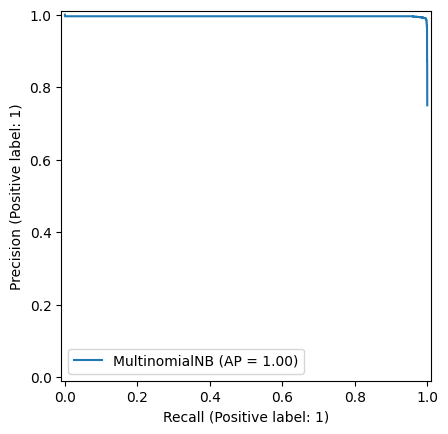

In [ ]:
metrics.PrecisionRecallDisplay.from_estimator(clasificador_final, X_test_completo, y_test)

Because the accuracy-recall curve is practically at 1 for almost all values ​​of τ, the choice of threshold does not significantly alter the classifier's performance. For simplicity and good results, we maintain the standard threshold τ = 0.5.

In [ ]:
def mostrar_correo(tipo, lista_indices):
    if len(lista_indices) > 0:
        i = lista_indices[0]  # we take the first one as an example
        print("\n======", tipo, "======")
        print(" Index in test:", i,
              " real tag:", y_test[i],
              " prob_spam:", p_spam_test[i])
        print("\nContent (first characters):\n")
        print(mails_test[i][:1000])  # trim if it's too long
    else:
        print("\n(There are no examples of type ", tipo, " with this threshold)")

# Index lists according to the type of hit/fail
indices_tp = []  # Well-classified SPAM
indices_tn = []  # Well-classified HAM
indices_fp = []  # HAM incorrectly classified as SPAM
indices_fn = []  # SPAM incorrectly classified as HAM

for i in range(len(y_test)):
    if y_test[i] == 1 and y_pred_test[i] == 1:
        indices_tp.append(i)
    elif y_test[i] == 0 and y_pred_test[i] == 0:
        indices_tn.append(i)
    elif y_test[i] == 0 and y_pred_test[i] == 1:
        indices_fp.append(i)
    elif y_test[i] == 1 and y_pred_test[i] == 0:
        indices_fn.append(i)


mostrar_correo("Well-classified SPAM (TP)", indices_tp)
mostrar_correo("Well-classified HAM (TN)", indices_tn)
mostrar_correo("HAM incorrectly classified as SPAM (FP)", indices_fp)
mostrar_correo("SPAM incorrectly classified as HAM (FN)", indices_fn)



====== SPAM bien clasificado (TP) ======
Índice en test: 0  etiqueta real: 1  prob_spam: 1.0

Contenido (primeros caracteres):

Subject: leading authority on stocks
u r g e n t i n v e s t o r a l e r t
orte stock expected to explode ! ! !
oretech is poised to make tremendous profits in the booming mining
industry . if you have been foliowing the markets lately , then you know
that mining stocks are hot . oretech is a company with a unique
opportunity to capitaiize off this red hot sector !
symbol : orte . pk
current price : $ o . 40
short term target price : $ 3 . 70
12 month target price : $ 9 . 8 o
c o m p a n y o v e r v i e w
oretech , inc . ( orte . pk ) has developed a proof of concept model that
represents a breakthrough in ore processing technoiogy . the process
utilizes a proprietary high temperature technique to extract various metais
from ore bodies that are typicaily highiy carbonaceous .
oretech , inc ' s business mode | is to become a major producer of gold and
other pr

Comments on the different email classification examples:

* Well-classified SPAM (TP): Clear signs of spam within the email.

* Well-classified HAM (TN): Content clearly belonging to the professional sphere.

* HAM misclassified as SPAM (FP): It is ham, however, it has several features that can be easily interpreted as spam: "special!", "click here to download", "unsubscribe"...

* Spam misclassified as HAM (FN): The email appears to simulate a "re [9]:" reply, so it is disguised spam.

---



